## Anomaly Detection using Isolation Forest

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1. Import dataset : Dataset used in this project is called "ForsetCover" from UCI machine learning repository:
https://archive.ics.uci.edu/ml/datasets/Covertype

In [2]:
#Import dataset ForestCover from csv file to a dataframe 
df = pd.read_csv('../Datasets/covtype.csv',header=None)
print(df.shape)
df.head()

(581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


#### This dataset has 54 attributes (10 quantitative variables, 4 binary wilderness areas and 40 binary soil type variables). Here, outlier detection dataset is created using only 10 quantitative attributes. 

In [3]:
df_forest = df[[0,1,2,3,4,5,6,7,8,9,54]]
df_forest.columns = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                     'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Cover_Type']
df_forest.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,5
1,2590,56,2,212,-6,390,220,235,151,6225,5
2,2804,139,9,268,65,3180,234,238,135,6121,2
3,2785,155,18,242,118,3090,238,238,122,6211,2
4,2595,45,2,153,-1,391,220,234,150,6172,5


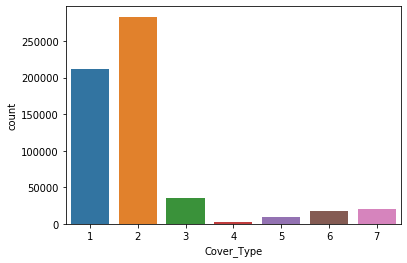

In [4]:
#class distribution

#1 -- Spruce/Fir
#2 -- Lodgepole Pine
#3 -- Ponderosa Pine
#4 -- Cottonwood/Willow
#5 -- Aspen
#6 -- Douglas-fir
#7 -- Krummholz

sns.countplot(df_forest.Cover_Type)

### 2. Data Cleaning : Instances from class 2 are considered as normal points and instances from class 4 are anomalies. Instances from the other classes are omitted.

In [5]:
df_forest_clean  = df_forest.loc[df_forest['Cover_Type'].isin([2,4])]

In [6]:
df_forest_clean.Cover_Type.value_counts()

2    283301
4      2747
Name: Cover_Type, dtype: int64

In [7]:
#class 2 is normal class denoted as 1
#class 4 is anomaly class denoted as -1
df_forest_clean['Cover_Type'] = df_forest_clean['Cover_Type'].apply(lambda x: 1 if x == 2 else -1)

In [8]:
# The anomalies ratio is 0.9%.
df_forest_clean.Cover_Type.value_counts(normalize = True)

 1    0.990397
-1    0.009603
Name: Cover_Type, dtype: float64

### 3. Model training : training isolation forest

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
X = df_forest_clean.iloc[:,0:9]
y = df_forest_clean.iloc[:,10]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [10]:
y_test.value_counts()

 1    56647
-1      563
Name: Cover_Type, dtype: int64

In [11]:
clf = IsolationForest(behaviour='new', contamination = 'auto',max_samples=512,random_state = 42)

In [12]:
#It is assumed that anomaly labels are unavailable in the training stage. 
#Anomaly labels are only available in the evaluation stage to compute the performance measure, AUC.
clf.fit(X_train)
y_pred = clf.predict(X_test)

### 4. Performance Measurement : AUC

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred, pos_label=1)
auc(fpr, tpr)

0.817695067151244

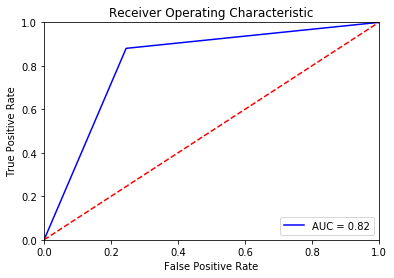

In [14]:
#AUC ROC plot
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### AUC = x indicates that there is x% chance that model will be able to distinguish between normal and anomaly instance. 
##### An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever.

In [15]:
print(tpr)
# % of the anomalies are correctly predicted as anomalies.

[0.         0.88050559 1.        ]


In [16]:
print(fpr)
#  % of the normal objects that are incorrectly predicted as anomalies

[0.         0.24511545 1.        ]
